# CS 109A/AC 209A/STAT 121A Data Science: Lab 7 (Solutions)
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>
**Due Date: ** Wednesday, November 2nd, 2016 at 11:59pm

Import libraries

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import mode
from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
%matplotlib inline

## Problem 1: Recommender System for Movies

In this problem, you will build a model to recommend movies using ratings from users. 

The dataset for this problem is contained in `dataset_4_ratings.txt`. This dataset contains ratings from 100 users for 1000 movies. The first two columns contain the user and movie IDs. The last column contains a 1 if the user liked the movie, and 0 otherwise. Not every movie is rated by every user (i.e. some movies have more ratings than others).

The names of the movies corresponding to the IDs are provided in `dataset_4_movie_names.txt`.

### Step 1: Read the data and explore

Let's get acquainted with our data.

In [2]:
ratings_df = pd.read_csv('datasets/dataset_4_ratings.txt', delimiter=',')
ratings_df.head()

,user_id,movie_id,rating
0,22.0,377.0,0.0
1,62.0,257.0,0.0
2,95.0,546.0,0.0
3,38.0,95.0,1.0
4,63.0,277.0,1.0


In [3]:
names_df = pd.read_csv('datasets/dataset_4_movie_names.txt', delimiter='|')
names_df.head()

,movie_id,movie_name,release_date,Unnamed: 3,link,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,NaN
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,NaN
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,NaN
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,NaN


It looks like movie names appear in the `names` dataframe but not in the `rating` dataframe. So we forsee a challenge later to cross reference a movie's id with its name. After all, it'd be more helpful to see the names of the movies in the top 25!

### Step 2: Implement a simple ranking system

One way of recommending movies is to recommend movies that are generally agreed upon to be good. But how do we measure the "goodness" or "likability" of a movie?

Suppose that we simple count the number of likes for each movie and take the 25 movies with the most number of likes. Would this be a good idea?

To help you extract the movie information from the two databases, we have built you a helper function.

In [4]:
#--------  movie_stats
# A function that extracts the number of likes and total number of ratings for a movie
# Input: 
#      movie_name (an optional parameter containing the exact name of the movie)
#      movie_name_contains (an optional parameter containing a portion of the name of the movie)
# Returns: 
#      total_ratings (the total number of ratings for a movie)
#      likes (the total number of likes for a movie)

def movie_stats(movie_name=None, movie_name_contains=None):
    
    #If given an exact movie name:
    if movie_name is not None:        
        #Find the index of the movie, by name, in the "names" dataframe
        movie_index = names_df[names_df['movie_name'] == movie_name].index[0]
        #Get the id for the movie in the "names" dataframe
        movie_id = names_df.loc[movie_index, 'movie_id']
        #Get all ratings for the movie, by id, in the "ratings" dataframe
        ratings_for_movie = ratings_df[ratings_df['movie_id'] == movie_id]
        #Count the total number of ratings
        total_ratings = len(ratings_for_movie)
        #Count the likes (the 1's)
        likes = ratings_for_movie['rating'].sum()
    
    #Otherwise, if given a partial movie name:
    elif movie_name_contains is not None:
        #Find the index of the movie, by name, in the "names" dataframe
        movie_index = names_df[names_df['movie_name'].str.contains(movie_name_contains)].index[0]
        #Get the id for the movie in the "names" dataframe
        movie_id = names_df.loc[movie_index, 'movie_id']
        #Get all ratings for the movie, by id, in the "ratings" dataframe
        ratings_for_movie = ratings_df[ratings_df['movie_id'] == movie_id]
        #Count the total number of ratings
        total_ratings = len(ratings_for_movie)
        #Count the likes (the 1's)
        likes = ratings_for_movie['rating'].sum()
    
    else:
        total_ratings = 0.
        likes = 0.
    
    return float(total_ratings), likes

Using the helper function above, let's check out the stats for a couple of movies:

In [5]:
total_ratings, likes = movie_stats(movie_name_contains='Toy Story')

print 'total number of ratings for Toy Story:', total_ratings
print 'number of likes for Toy Story:', likes

total number of ratings for Toy Story: 51.0
number of likes for Toy Story: 38.0


In [6]:
total_ratings, likes = movie_stats(movie_name_contains="Shawshank Redemption")

print 'total number of ratings for Star Wars:', total_ratings
print 'number of likes for Star Wars:', likes

total number of ratings for Star Wars: 39.0
number of likes for Star Wars: 39.0


In [7]:
total_ratings, likes = movie_stats(movie_name_contains='French Twist')

print 'total number of ratings for French Twist:', total_ratings
print 'number of likes for French Twist:', likes

total number of ratings for French Twist: 2.0
number of likes for French Twist: 2.0


Clearly, not all movies have the same number of ratings. Now, if we want to rank the movies by the total number of likes, we'd have to rank "Toy Story" and "Shawshank Redemption" as similarly likable. Does this seem fair to you? Meaning, does our ranking reflect the likability of the movie based on the complete ratings information?

### Step 3: Implement a fairer ranking system

Now, instead of using the total number of likes, we use the total percentage of likes to rank the movies. Why is total like-percentage a more reasonable metric for likability than total number of likes? There is an intuitive, layman's explanation for this choice and there is a formal probabilistic way of justifying this choice.

So what does the top 25 movies loook like when we rank by like-percentage?

In [8]:
#Make a list of movie names and their ratings info
likability = []

#Iterate through all the movie names
for name in names_df['movie_name'].values:
    #Get ratings info for movie
    total_ratings, likes = movie_stats(movie_name=name)
    #Add movie info to our list
    likability.append((name, likes, total_ratings, likes / total_ratings))

#Sort our list of movie info by like-percentage, in descending order
sorted_likability = sorted(likability, key=lambda t: t[3], reverse=True)  
#Get the movies with top 25 like-percentage
top_25_movies = sorted_likability[:25]

#Print results of ranking
print 'Top 25 Movies'
print '****************************'
for movie, likes, total_ratings, likable in top_25_movies:
    print movie, ':', likable, '({}/{})'.format(likes, total_ratings)

Top 25 Movies
****************************
French Twist (Gazon maudit) (1995) : 1.0 (2.0/2.0)
Exotica (1994) : 1.0 (2.0/2.0)
Three Colors: Red (1994) : 1.0 (12.0/12.0)
Three Colors: White (1994) : 1.0 (8.0/8.0)
Shawshank Redemption, The (1994) : 1.0 (39.0/39.0)
Brother Minister: The Assassination of Malcolm X (1994) : 1.0 (1.0/1.0)
Carlito's Way (1993) : 1.0 (4.0/4.0)
Robert A. Heinlein's The Puppet Masters (1994) : 1.0 (2.0/2.0)
Horseman on the Roof, The (Hussard sur le toit, Le) (1995) : 1.0 (2.0/2.0)
Wallace & Gromit: The Best of Aardman Animation (1996) : 1.0 (6.0/6.0)
Maya Lin: A Strong Clear Vision (1994) : 1.0 (1.0/1.0)
Unhook the Stars (1996) : 1.0 (1.0/1.0)
Wrong Trousers, The (1993) : 1.0 (14.0/14.0)
Godfather: Part II, The (1974) : 1.0 (18.0/18.0)
Ridicule (1996) : 1.0 (5.0/5.0)
Pillow Book, The (1995) : 1.0 (2.0/2.0)
When the Cats Away (Chacun cherche son chat) (1996) : 1.0 (3.0/3.0)
unknown : 1.0 (2.0/2.0)
Once Upon a Time... When We Were Colored (1995) : 1.0 (2.0/2.0)
Ass

We notice that "Shawshank Redemption" now far out ranks "Toy Story". This seems more reasonable. On the other hand, "French Twist" also, now, far out ranks "Toy Story". Does this seem fair? In fact, take a look at your top 25 movies, do you feel like this list best represents the most "popular" or "beloved" movies in the database? If not, why isn't our ranking system doing a good job (what's wrong with ranking by like-percentage)?

### Part 4: Exploring the effect of prior beliefs

Recall that we can predjudice our models (if we don't like their results) by building in some prior beliefs about the model parameters. In this case, our model parameter is "the likability of a movie". So let's encode some prior beliefs for what we think are reasonable values for "likability". To keep things simple, we will restrict ourselves to using beta priors to model our beliefs about "likability".

We have built for you a few helpful functions: one to help you visualize the pdf for various beta priors, one for approximating the posterior using samples, and one for calculating the mode of a distribution (given by some sampled values).

In [9]:
#--------  plot_beta_prior
# A function to visualize a beta pdf on a set of axes
# Input: 
#      a (parameter controlling shape of beta prior)
#      b (parameter controlling shape of beta prior)
#      color (color of beta pdf)
#      ax (axes on which to plot pdf)
# Returns: 
#      ax (axes with plot of beta pdf)

def plot_beta_prior(a, b, color, ax):
    
    #Create a beta-distributed random variable with shape a, b
    rv = sp.stats.beta(a, b)
    #Create values from 0 to 1
    x = np.linspace(0, 1, 100)
    #Plot the beta pdf for values from 0 to 1
    ax.plot(x, rv.pdf(x), '-', lw=2, color=color, label='a=' + str(a) + ', b=' + str(b))
    #Set title, legend etc
    ax.set_title('Beta prior with a=' + str(a) + ', b=' + str(b))
    ax.legend(loc='best')
    
    return ax

In [10]:
#--------  sample_posterior
# A function that samples points from the posterior over a movie's 
# likability, given a binomial likelihood function and beta prior
# Input: 
#      a (parameter controlling shape of beta prior)
#      b (parameter controlling shape of beta prior)
#      likes (the number of likes in likelihood)
#      ratings (total number of ratings in likelihood)
#      n_samples (number of samples to take from posterior)
# Returns: 
#      post_samples (a array of points from the posterior)

def sample_posterior(a, b, likes, ratings, n_samples):
    #Samples points from a beta distribution 
    #(the posterior of a binomial likelihood and a beta prior is a beta distribution!)
    post_samples = np.random.beta(a + likes, b + ratings - likes, n_samples)
    return post_samples

In [11]:
#--------  find_mode
# A function that approximates the mode of a distribution given a sample from the distribution
# Input: 
#      values (samples from the distribution)
#      num_bins (number of bins to use in approximating histogram)
# Returns: 
#      mode (the approximate mode of the distribution)

def find_mode(values, num_bins):
    
    #Make an approximation (histogram) of the distribution using the samples
    bins, edges = np.histogram(values, bins=num_bins)
    #Find the bin in the histogram with the max height
    max_height_index = np.argmax(bins)
    #Find the sample corresponding to the bin with the max height (the mode)
    mode = (edges[max_height_index] + edges[max_height_index + 1]) / 2.
    
    return mode

First, let's explore the shapes of various beta pdfs and let's interpret these shapes as prior beliefs (stated in plain English).

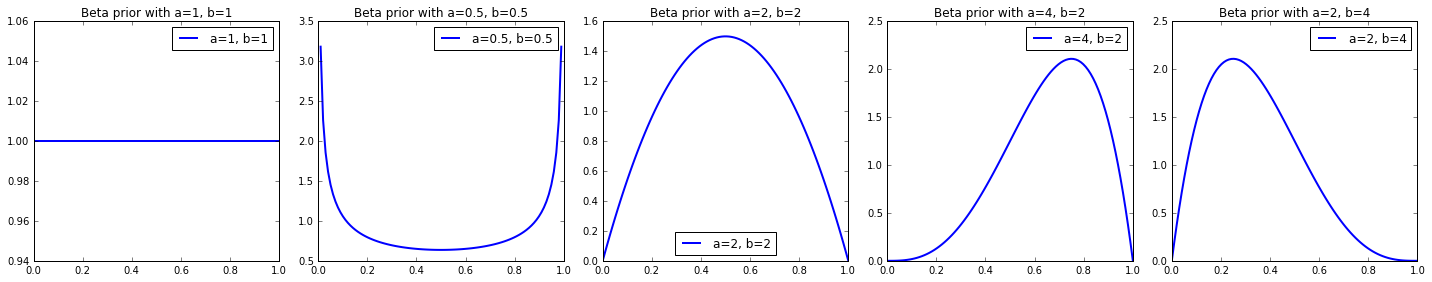

In [12]:
#A list of beta distribution shapes to try out
beta_shapes = [(1, 1), (0.5, 0.5), (2, 2), (4, 2), (2, 4)]
#Length of the list of shapes
n = len(beta_shapes)

#Plot all the beta pdfs in a row
fig, ax = plt.subplots(1, n, figsize=(20, 4))

#Start the index of the current subplot at 0
ax_ind = 0
#Iterate through all the shapes
for a, b in beta_shapes:
    #Plot the beta pdf for a particular shape
    plot_beta_prior(a, b, 'blue', ax[ax_ind])
    #Increment the subplot index
    ax_ind += 1
    
plt.tight_layout()    
plt.show() 

So, which beta prior encodes an appropriate belief about likability? If this is a difficult question to answer, let's look at the effect of the priors on the posterior (i.e. the likelihood of a particular "likelihood" given a set of observed ratings). 

Shawshank Redemption, The (1994): 0.980050596558 (39.0/39.0)


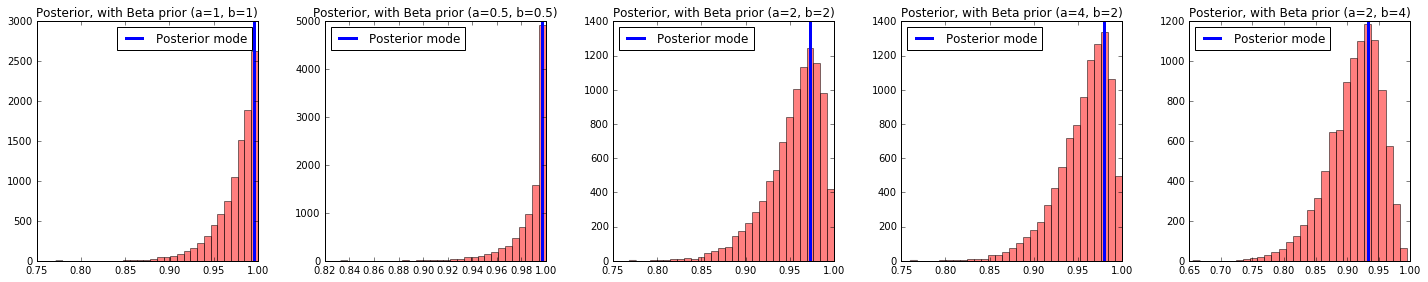

In [15]:
#Get the name of the first movie in the top 25 list
movie_name = top_25_movies[0][0]

#Get the ratings info for the first movie in the top 25 list
likes = top_25_movies[0][1]
total_ratings = top_25_movies[0][2]
likability = top_25_movies[0][3]

#Print movie info
print '{}: {} ({}/{})'.format(movie_name, likability, likes, total_ratings)

#Number of samples to use when approximating our posterior
n_samples = 10000

#Plot the posterior corresponding to each prior
fig, ax = plt.subplots(1, n, figsize=(20, 4))

#Start the index of the current subplot at 0
ax_ind = 0

#Iterate through all the shapes
for a, b in beta_shapes:   
    #Draw samples from the posterior corresponding to a particular beta prior
    post_samples = sample_posterior(a, b, likes, total_ratings, n_samples)
    #Approximate the posterior with a histogram of these samples
    ax[ax_ind].hist(post_samples, bins=30, color='red', alpha=0.5)
    #Find the approximate mode of the posterior
    mode = find_mode(post_samples, 30)
    #Plot the mode as a vertical line
    ax[ax_ind].axvline(x=mode, linewidth=3, label='Posterior mode')
    
    #Set title, legends etc
    ax[ax_ind].set_title('Posterior, with Beta prior (a={}, b={})'.format(a, b))
    ax[ax_ind].legend(loc='best')
    #Increment the subplot index
    ax_ind += 1

plt.tight_layout()
plt.show() 

So, how do we interpret the posterior? I.e. what is it telling us about the likability of a particular movie? 

How do we interpret the posterior mode? What does the mode tell us about the likability of a particular movie?

Do the posterior mode tell us the same thing about a movie's likability as the like-percentage? Which metric is more realistic or reasonable?

### Step 5: Implement a ranking system that takes prior beliefs into account

Let's choose a reasonable beta prior and build a list of top 25 movies that you would recommend to a new user based on the posterior mode.

Why is this reasonable to do? There is an intuitive, layman's explanation for this as well as a formal statistical justification.

In [14]:
#Choose a beta prior that encodes a reasonable belief about likability 
a = 2 
b = 2

#Make a list of movie names and their ratings info
likability = []

#Iterate through all the movie names
for name in names_df['movie_name'].values:
    #Get ratings info for movie
    total_ratings, likes = movie_stats(movie_name=name)
    #Approximate the posterior given the ratings info and the prior
    post_samples = sample_posterior(a, b, likes, total_ratings, n_samples)
    #Approximate posterior mode
    mode = find_mode(post_samples, 30)
    #Add movie info to our list
    likability.append((name, likes, total_ratings, mode))

#Sort our list of movie info by like-percentage, in descending order
sorted_likability = sorted(likability, key=lambda t: t[3], reverse=True)  
#Get the movies with top 25 like-percentage
top_25_movies = sorted_likability[:25]

#Print results of ranking
print 'Top 25 Movies'
print '****************************'
for movie, likes, total_ratings, likable in top_25_movies:
    print movie, ':', likable, '({}/{})'.format(likes, total_ratings)

Top 25 Movies
****************************
Shawshank Redemption, The (1994) : 0.980050596558 (39.0/39.0)
Cool Hand Luke (1967) : 0.950348590374 (20.0/20.0)
Glory (1989) : 0.947718889527 (17.0/17.0)
Godfather: Part II, The (1974) : 0.946339121611 (18.0/18.0)
Manchurian Candidate, The (1962) : 0.94391760832 (17.0/17.0)
Raiders of the Lost Ark (1981) : 0.941229442549 (47.0/49.0)
Killing Fields, The (1984) : 0.939476820729 (14.0/14.0)
Wrong Trousers, The (1993) : 0.935706879036 (14.0/14.0)
Three Colors: Red (1994) : 0.933080679279 (12.0/12.0)
High Noon (1952) : 0.925864598073 (11.0/11.0)
Casablanca (1942) : 0.925090033068 (22.0/23.0)
Close Shave, A (1995) : 0.9229749494 (16.0/17.0)
Alien (1979) : 0.911512265727 (28.0/30.0)
Vertigo (1958) : 0.910364992093 (22.0/23.0)
Wallace & Gromit: The Best of Aardman Animation (1996) : 0.909394477098 (6.0/6.0)
Local Hero (1983) : 0.909071373145 (10.0/10.0)
East of Eden (1955) : 0.904421921802 (8.0/8.0)
Dead Man Walking (1995) : 0.902970435 (33.0/36.0)
T

So while "Shawshank Redemption" is still highly ranked, "French Twist" no longer appears on our top 25. This at least seems more intuitive.

So, in what important ways is our top 25 list using the posterior mode different from our top 25 list using the like-percent? Which list is, generally speaking, more realistic and why?

---